## 1. Environment Setup

In [4]:
import openai
openai.api_key = open("openai_key.txt", "r").read()

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import gensim
from gensim import corpora
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import ast
import re

## 2. Load & Explore Shopee Reviews Dataset

In [188]:
# Read the xlsx file
givaudan_df = pd.read_excel('Givaudan/all_reviews_translated.xlsx')

givaudan_df.head()

,Brand,Product,Product Name,Product URL,Qty Sold,No of Reviews,Avg Rating,Username,Review Date,Translation
0,Saff & Co shopee,Loui,SAFF & Co. Extrait de Parfum - LOUI,https://shopee.co.id/SAFF-Co.-Extrait-de-Parfu...,10000,238000,4.9,a*****r,11/16/2022,Texture liquid Performance lasts long enough 4...
1,Saff & Co shopee,Loui,SAFF & Co. Extrait de Parfum - LOUI,https://shopee.co.id/SAFF-Co.-Extrait-de-Parfu...,10000,238000,4.9,f*****r,09/13/2022,Performance Fragrance Suitable For Perfume Tex...
2,Saff & Co shopee,Loui,SAFF & Co. Extrait de Parfum - LOUI,https://shopee.co.id/SAFF-Co.-Extrait-de-Parfu...,10000,238000,4.9,w*****n,06/30/2023,Suitable For daily use Texture liquid Performa...
3,Saff & Co shopee,Loui,SAFF & Co. Extrait de Parfum - LOUI,https://shopee.co.id/SAFF-Co.-Extrait-de-Parfu...,10000,238000,4.9,pegiangelia,10/19/2022,Suitable For unisex Texture liquid Performance...
4,Saff & Co shopee,Loui,SAFF & Co. Extrait de Parfum - LOUI,https://shopee.co.id/SAFF-Co.-Extrait-de-Parfu...,10000,238000,4.9,c*****a,07/12/2021,"Packaging very unique and nice, safe and no le..."


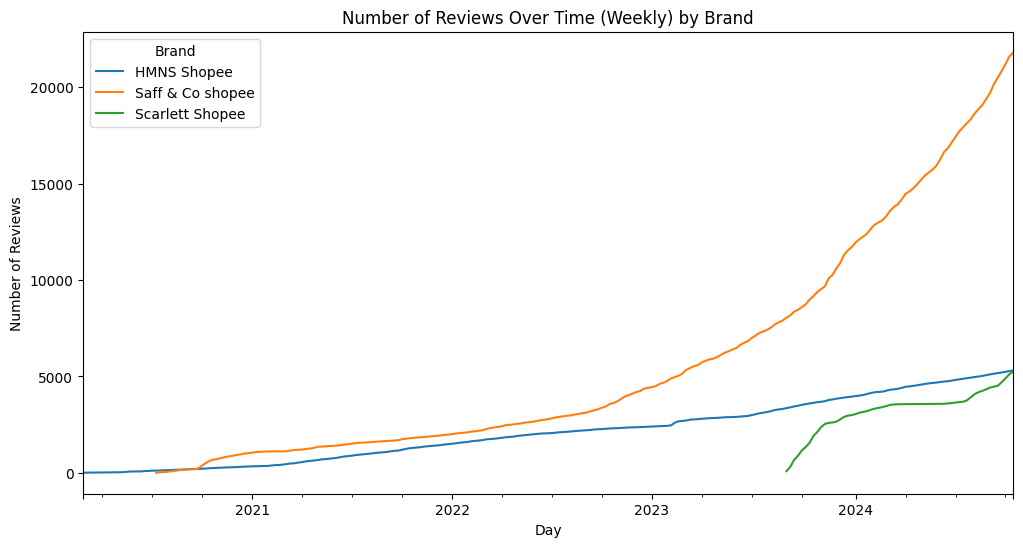

In [189]:
givaudan_df['Review Date'] = pd.to_datetime(givaudan_df['Review Date'])

# Group reviews by week
weekly_comments = givaudan_df.groupby('Brand').resample('W', on='Review Date').size().unstack(level=0).cumsum()

# Plot the data
weekly_comments.plot(kind='line', figsize=(12, 6))
plt.xlabel('Day')
plt.ylabel('Number of Reviews')
plt.title('Number of Reviews Over Time (Weekly) by Brand')
plt.legend(title='Brand')
plt.show()

## 3. Topic Modelling

In [190]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

givaudan_df['Translation'] = givaudan_df['Translation'].astype(str)
all_text = ' '.join(givaudan_df['Translation'])

# Preprocess the text data
stop_words = set(stopwords.words('english'))

def preprocess(text):
    if isinstance(text, str):
        tokens = word_tokenize(text.lower())
        tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
        return tokens
    return []

processed_text = preprocess(all_text)

# Create a dictionary and corpus
dictionary = corpora.Dictionary([processed_text])
corpus = [dictionary.doc2bow(processed_text)]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\leeju\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\leeju\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\leeju\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [191]:
# Train the LDA model
lda_model = gensim.models.LdaModel(corpus, num_topics=1, id2word=dictionary, passes=15)

# Display the topics
topics = lda_model.print_topics(num_words=1000)

words = topics[0][1].split(' + ')
word_weights = {}

for word in words:
    word = word.split('*')
    word[0] = float(word[0])
    word[1] = word[1].strip('"')
    word_weights[word[1]] = word[0]
print(word_weights)

{'scent': 0.041, 'fragrance': 0.023, 'really': 0.022, 'nice': 0.021, 'good': 0.017, 'like': 0.016, 'packaging': 0.016, 'texture': 0.015, 'perfume': 0.013, 'longevity': 0.012, 'got': 0.012, 'suitable': 0.011, 'love': 0.01, 'lasts': 0.01, 'sweet': 0.01, 'long': 0.009, 'longlasting': 0.009, 'smells': 0.008, 'thank': 0.008, 'time': 0.008, 'liquid': 0.007, 'fresh': 0.007, 'fast': 0.007, 'arrived': 0.006, 'super': 0.006, 'performance': 0.006, 'fragrant': 0.006, 'tester': 0.006, 'first': 0.006, 'soft': 0.006, 'safe': 0.006, 'bought': 0.005, 'saff': 0.005, 'one': 0.005, 'also': 0.005, 'delivery': 0.005, 'tried': 0.005, 'thanks': 0.005, 'okay': 0.005, 'still': 0.005, 'hours': 0.005, 'strong': 0.004, 'even': 0.004, 'ð': 0.004, 'buy': 0.004, 'quite': 0.004, 'product': 0.004, 'seller': 0.004, 'bit': 0.004, 'smell': 0.004, 'sotb': 0.003, 'yet': 0.003, 'next': 0.003, 'hope': 0.003, 'dont': 0.003, 'try': 0.003, 'co': 0.003, 'much': 0.003, 'day': 0.003, 'floral': 0.003, 'durability': 0.003, 'variant':

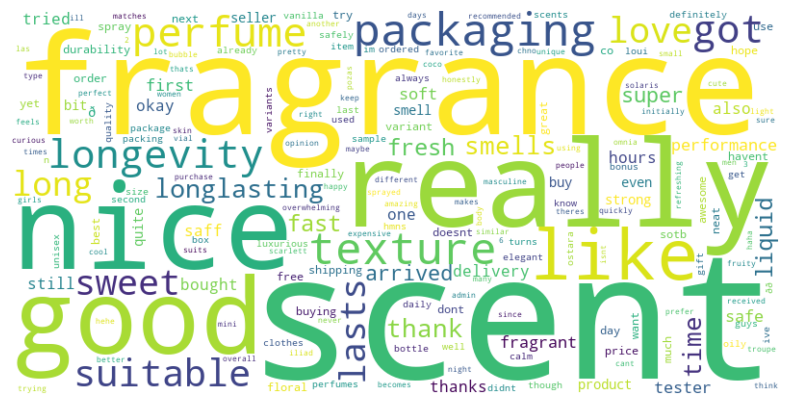

In [192]:
from wordcloud import WordCloud

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_weights)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## 4. Sentiment Generation with ChatGPT API

In [13]:
# Define the categories and sentiments
sentiments = ["positive", "neutral", "negative"]

# Function to get categories for a reviews
def get_review_categories(review):
    response = openai.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {
                "role": "user",
                "content": f"First, identify categories for the following review: '{review}'. Choose categories, only limited to the following 1-7:.\
                    1. Scent: related to smell quality of product, eg. fragrance, strength, etc.\
                    2. Longevity: related to duration of product, eg. how long it lasts, etc.\
                    3. Price: related to cost of purchase, eg. value for money, affordability, etc.\
                    4. Packaging: related to appearance of product, not affected by delivery condition, eg. ease of storage, size, design, etc.\
                    5. Delivery: related to shipping and condition upon delivery, eg. speed, tracking, message before delivery, dents etc.\
                    6. Customer Service: related to seller behaviour, not including thanking seller, eg. response speed, refund speed, attitude etc.\
                    7. Texture: related to physical feel of product, eg. smooth, light and liquid are positive, thick and oily is negative etc.\
                    Then, for each category selected, sentiment is also selected, including: {', '.join(sentiments)}.\
                    Respond in a dictionary starting and ending with curly brackets only, format: \"category1\": \"sentiment1\", \"category2\": \"sentiment2\""
            }
        ]
    )
    return response.choices[0].message.content

In [36]:
random_df = givaudan_df.sample(4000).sort_index()
random_df.reset_index(drop=True, inplace=True)
batch_size = 50
min = 0
max = len(random_df)
for start in range(min, max, batch_size):
    end = start + batch_size
    if end > max:
        end = max
    random_df.loc[start:end, 'Categories'] = random_df.loc[start:end, 'Translation'].apply(get_review_categories)
    random_df.to_excel(f'Givaudan/Random_with_Categories.xlsx', index=False)
    print(f"Processed {start} to {end} reviews")

Processed 0 to 50 reviews
Processed 50 to 100 reviews
Processed 100 to 150 reviews
Processed 150 to 200 reviews
Processed 200 to 250 reviews
Processed 250 to 300 reviews
Processed 300 to 350 reviews
Processed 350 to 400 reviews
Processed 400 to 450 reviews
Processed 450 to 500 reviews
Processed 500 to 550 reviews
Processed 550 to 600 reviews
Processed 600 to 650 reviews
Processed 650 to 700 reviews
Processed 700 to 750 reviews
Processed 750 to 800 reviews
Processed 800 to 850 reviews
Processed 850 to 900 reviews
Processed 900 to 950 reviews
Processed 950 to 1000 reviews
Processed 1000 to 1050 reviews
Processed 1050 to 1100 reviews
Processed 1100 to 1150 reviews
Processed 1150 to 1200 reviews
Processed 1200 to 1250 reviews
Processed 1250 to 1300 reviews
Processed 1300 to 1350 reviews
Processed 1350 to 1400 reviews
Processed 1400 to 1450 reviews
Processed 1450 to 1500 reviews
Processed 1500 to 1550 reviews
Processed 1550 to 1600 reviews
Processed 1600 to 1650 reviews
Processed 1650 to 17

## 5. Clean ChatGPT API Outputs

In [12]:
categories_df = pd.read_excel('Givaudan/Random_with_Categories.xlsx')
categories_df.head()

,Brand,Product,Product Name,Product URL,Qty Sold,No of Reviews,Avg Rating,Username,Review Date,Translation,Categories
0,Saff & Co shopee,Loui,SAFF & Co. Extrait de Parfum - LOUI,https://shopee.co.id/SAFF-Co.-Extrait-de-Parfu...,10000,238000,4.9,f*****r,09/13/2022,Performance Fragrance Suitable For Perfume Tex...,"{\n ""Scent"": ""positive"",\n ""Longevity"": ..."
1,Saff & Co shopee,Loui,SAFF & Co. Extrait de Parfum - LOUI,https://shopee.co.id/SAFF-Co.-Extrait-de-Parfu...,10000,238000,4.9,w*****n,06/30/2023,Suitable For daily use Texture liquid Performa...,"{\n ""Scent"": ""positive"",\n ""Price"": ""pos..."
2,Saff & Co shopee,Loui,SAFF & Co. Extrait de Parfum - LOUI,https://shopee.co.id/SAFF-Co.-Extrait-de-Parfu...,10000,238000,4.9,ajengsr,01/29/2023,"Wow, the delivery was really fast. Only took a...","{\n ""Scent"": ""positive"",\n ""Delivery"": ""..."
3,Saff & Co shopee,Loui,SAFF & Co. Extrait de Parfum - LOUI,https://shopee.co.id/SAFF-Co.-Extrait-de-Parfu...,10000,238000,4.9,enseateaaa,12/15/2022,Performance dont know yet Suitable For unisex ...,"{\n ""Scent"": ""positive"",\n ""Texture"": ""p..."
4,Saff & Co shopee,Loui,SAFF & Co. Extrait de Parfum - LOUI,https://shopee.co.id/SAFF-Co.-Extrait-de-Parfu...,10000,238000,4.9,irna_mayang62sari,10/01/2022,Texture good Performance good Suitable For eve...,"{\n ""Scent"": ""positive"",\n ""Texture"": ""p..."


In [18]:
# Function to convert string representation of dictionary to actual dictionary
def convert_to_dict(entry):
    try:
        return ast.literal_eval(entry)
    except (ValueError, SyntaxError):
        return entry

# Apply the function to the "Categories" column
categories_df['Categories'] = categories_df['Categories'].apply(convert_to_dict)

# Find the indexes of cells that have errors (i.e., None values)
error_indexes = categories_df[~categories_df['Categories'].apply(lambda x: isinstance(x, dict))].index.tolist()

# Get the total count of errors
total_errors = len(error_indexes)

# Print the indexes and the total count of errors
print(f"Indexes of cells with errors: {error_indexes}")
print(f"Total number of errors: {total_errors}")

Indexes of cells with errors: [407, 419, 476, 501, 511, 578, 818, 1415, 1588, 1649, 1666, 2263, 2273, 2470, 2500, 2510, 2709, 2974, 2976, 3399, 3414, 3441, 3568, 3833, 3941, 3965, 3974]
Total number of errors: 27


In [ ]:
def extract_dict(entry):
    match = re.search(r'\{.*?\}', entry)
    if match:
        try:
            return ast.literal_eval(match.group(0))
        except (ValueError, SyntaxError):
            print(f"Error converting {match.group(0)}")
            return entry
    return entry

# Convert error entries to dictionaries by extracting the portion with {}
for index in error_indexes:
    categories_df.at[index, 'Categories'] = extract_dict(categories_df.at[index, 'Categories'])

In [16]:
categories_df['Review Date'] = pd.to_datetime(categories_df['Review Date'])
categories_df.to_excel(f'Givaudan/Random_with_Categories.xlsx', index=False)
# categories_df.head()

,Brand,Product,Product Name,Product URL,Qty Sold,No of Reviews,Avg Rating,Username,Review Date,Translation,Categories
0,Saff & Co shopee,Loui,SAFF & Co. Extrait de Parfum - LOUI,https://shopee.co.id/SAFF-Co.-Extrait-de-Parfu...,10000,238000,4.9,f*****r,2022-09-13,Performance Fragrance Suitable For Perfume Tex...,"{\n ""Scent"": ""positive"",\n ""Longevity"": ..."
1,Saff & Co shopee,Loui,SAFF & Co. Extrait de Parfum - LOUI,https://shopee.co.id/SAFF-Co.-Extrait-de-Parfu...,10000,238000,4.9,w*****n,2023-06-30,Suitable For daily use Texture liquid Performa...,"{\n ""Scent"": ""positive"",\n ""Price"": ""pos..."
2,Saff & Co shopee,Loui,SAFF & Co. Extrait de Parfum - LOUI,https://shopee.co.id/SAFF-Co.-Extrait-de-Parfu...,10000,238000,4.9,ajengsr,2023-01-29,"Wow, the delivery was really fast. Only took a...","{\n ""Scent"": ""positive"",\n ""Delivery"": ""..."
3,Saff & Co shopee,Loui,SAFF & Co. Extrait de Parfum - LOUI,https://shopee.co.id/SAFF-Co.-Extrait-de-Parfu...,10000,238000,4.9,enseateaaa,2022-12-15,Performance dont know yet Suitable For unisex ...,"{\n ""Scent"": ""positive"",\n ""Texture"": ""p..."
4,Saff & Co shopee,Loui,SAFF & Co. Extrait de Parfum - LOUI,https://shopee.co.id/SAFF-Co.-Extrait-de-Parfu...,10000,238000,4.9,irna_mayang62sari,2022-10-01,Texture good Performance good Suitable For eve...,"{\n ""Scent"": ""positive"",\n ""Texture"": ""p..."


## 6. Calculate Average Sentiment Value for each review

In [29]:
# Define the sentiment values
sentiment_mapping = {
    'positive': 1,
    'neutral': 0,
    'negative': -1
}

# Function to calculate the average sentiment
def calculate_average_sentiment(category_dict):
    # category_dict = ast.literal_eval(category_dict_str)
    sentiments = [sentiment_mapping.get(sentiment, 0) for sentiment in category_dict.values()]
    if sentiments:
        return sum(sentiments) / len(sentiments)
    return 0

# Apply the function to create a new column 'Average_Sentiment'
categories_df['Average_Sentiment'] = categories_df['Categories'].apply(calculate_average_sentiment)

# Display the first few rows to verify
categories_df.head()

,Brand,Product,Product Name,Product URL,Qty Sold,No of Reviews,Avg Rating,Username,Review Date,Translation,Categories,Average_Sentiment
0,Saff & Co shopee,Loui,SAFF & Co. Extrait de Parfum - LOUI,https://shopee.co.id/SAFF-Co.-Extrait-de-Parfu...,10000,238000,4.9,f*****r,09/13/2022,Performance Fragrance Suitable For Perfume Tex...,"{'Scent': 'positive', 'Longevity': 'positive',...",1.0
1,Saff & Co shopee,Loui,SAFF & Co. Extrait de Parfum - LOUI,https://shopee.co.id/SAFF-Co.-Extrait-de-Parfu...,10000,238000,4.9,w*****n,06/30/2023,Suitable For daily use Texture liquid Performa...,"{'Scent': 'positive', 'Price': 'positive', 'Pa...",0.8
2,Saff & Co shopee,Loui,SAFF & Co. Extrait de Parfum - LOUI,https://shopee.co.id/SAFF-Co.-Extrait-de-Parfu...,10000,238000,4.9,ajengsr,01/29/2023,"Wow, the delivery was really fast. Only took a...","{'Scent': 'positive', 'Delivery': 'positive'}",1.0
3,Saff & Co shopee,Loui,SAFF & Co. Extrait de Parfum - LOUI,https://shopee.co.id/SAFF-Co.-Extrait-de-Parfu...,10000,238000,4.9,enseateaaa,12/15/2022,Performance dont know yet Suitable For unisex ...,"{'Scent': 'positive', 'Texture': 'positive'}",1.0
4,Saff & Co shopee,Loui,SAFF & Co. Extrait de Parfum - LOUI,https://shopee.co.id/SAFF-Co.-Extrait-de-Parfu...,10000,238000,4.9,irna_mayang62sari,10/01/2022,Texture good Performance good Suitable For eve...,"{'Scent': 'positive', 'Texture': 'positive', '...",1.0


## 7. Identify root cause of sentiment drop in specific periods

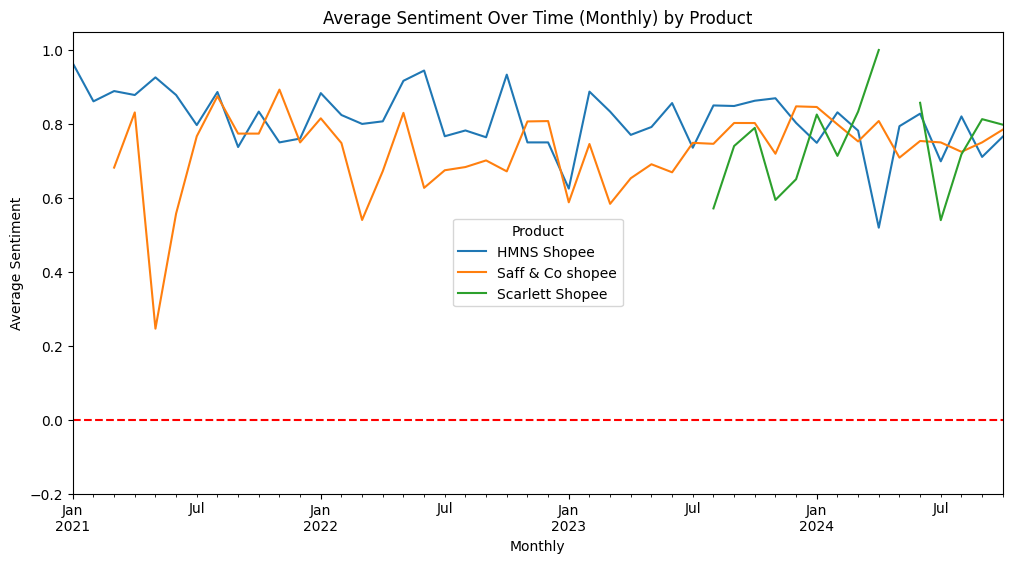

In [173]:
import matplotlib.dates as mdates

categories_df['Review Date'] = pd.to_datetime(categories_df['Review Date'])
biweekly_sentiments_by_product = categories_df.groupby([pd.Grouper(key='Review Date', freq='M'), 'Brand'])['Average_Sentiment'].mean().unstack()

# Plot the data
plt.figure(figsize=(12, 6))
biweekly_sentiments_by_product.plot(kind='line', ax=plt.gca())
plt.axhline(y=0, color='red', linestyle='--')  # Add a red line at y=0
plt.xlabel('Monthly')
plt.ylabel('Average Sentiment')
plt.title('Average Sentiment Over Time (Monthly) by Brand')
plt.xlim(pd.Timestamp('2021-01-01'), pd.Timestamp('2024-10-31'))
plt.ylim(-0.2, 1.05)  # Set y-axis limits

# # Set x-axis major locator to month and formatter to show month and year in mm/yy format
# plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))

# # Show alternate labels
# xticks = plt.gca().get_xticks()
# plt.gca().set_xticks(xticks[::3])

plt.legend(title='Product')
plt.show()

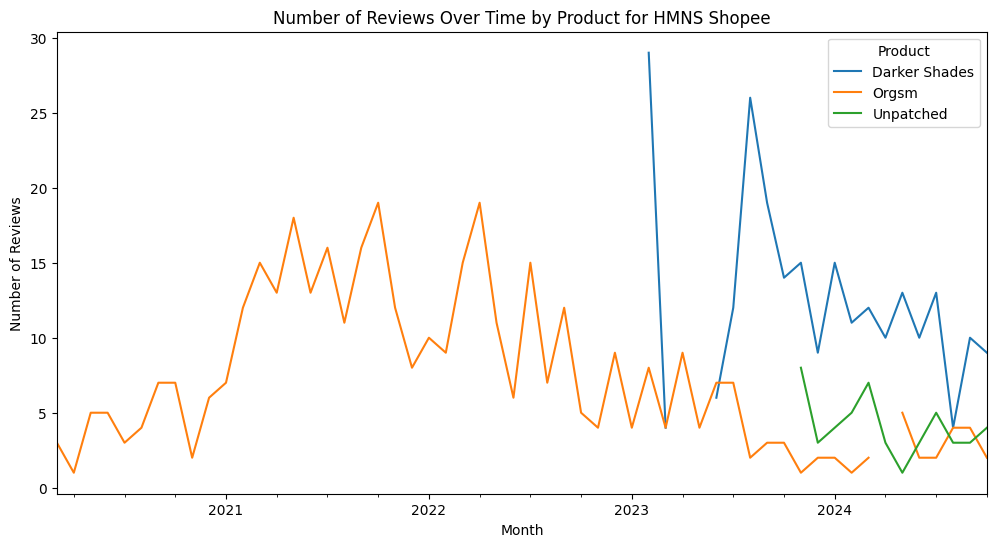

In [14]:
# Filter the dataframe for "HMNS Shopee" brand
hmns_df = categories_df[categories_df['Brand'] == 'HMNS Shopee']

# Group by Review Date and Product, then count the number of reviews
monthly_reviews_by_product = hmns_df.groupby([pd.Grouper(key='Review Date', freq='M'), 'Product']).size().unstack()

# Plot the data
plt.figure(figsize=(12, 6))
monthly_reviews_by_product.plot(kind='line', ax=plt.gca())
plt.xlabel('Month')
plt.ylabel('Number of Reviews')
plt.title('Number of Reviews Over Time by Product for HMNS Shopee')
plt.legend(title='Product')
plt.show()

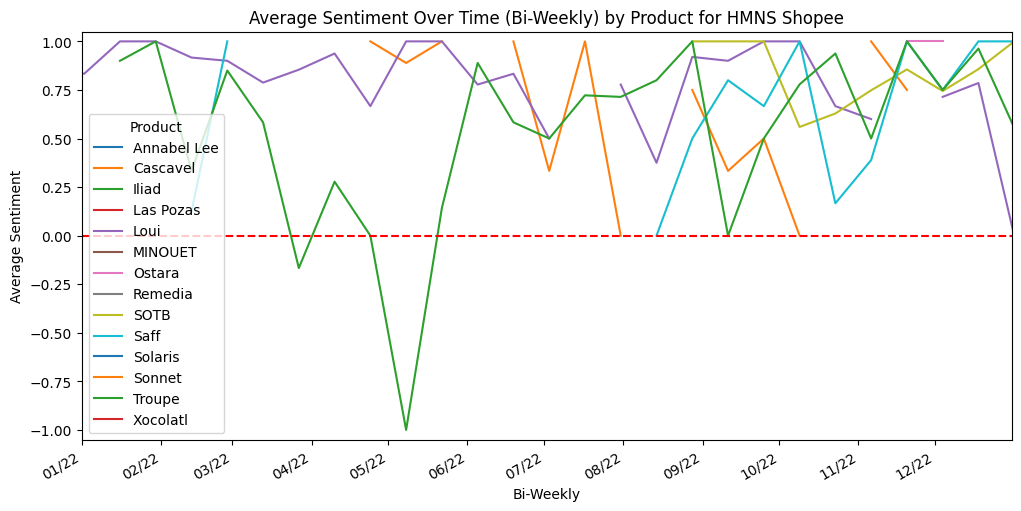

In [185]:
# Filter the dataframe for "HMNS Shopee" brand
saff_co_df = categories_df[categories_df['Brand'] == 'Saff & Co shopee']

# Group by Review Date and Product, then calculate the mean Average_Sentiment
biweekly_sentiments_by_product = saff_co_df.groupby([pd.Grouper(key='Review Date', freq='2W'), 'Product'])['Average_Sentiment'].mean().unstack()

# Plot the data
plt.figure(figsize=(12, 6))
biweekly_sentiments_by_product.plot(kind='line', ax=plt.gca())
plt.axhline(y=0, color='red', linestyle='--')  # Add a red line at y=0
plt.xlabel('Bi-Weekly')
plt.ylabel('Average Sentiment')
plt.title('Average Sentiment Over Time (Bi-Weekly) by Product for HMNS Shopee')
plt.xlim(pd.Timestamp('2022-01-01'), pd.Timestamp('2022-12-31'))
plt.ylim(-1.05, 1.05)  # Set y-axis limits

# Set x-axis major locator to month and formatter to show month and year in mm/yy format
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))

# Show alternate labels
xticks = plt.gca().get_xticks()
plt.gca().set_xticks(xticks[::1])

plt.legend(title='Product')
plt.show()

C:\Users\leeju\AppData\Local\Temp\ipykernel_31508\3076473343.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orgsm_df[f'{category}_sentiment'] = orgsm_df['Categories'].apply(lambda x: extract_category_sentiment(x, category))
C:\Users\leeju\AppData\Local\Temp\ipykernel_31508\3076473343.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orgsm_df[f'{category}_sentiment'] = orgsm_df['Categories'].apply(lambda x: extract_category_sentiment(x, category))
C:\Users\leeju\AppData\Local\Temp\ipykernel_31508\30

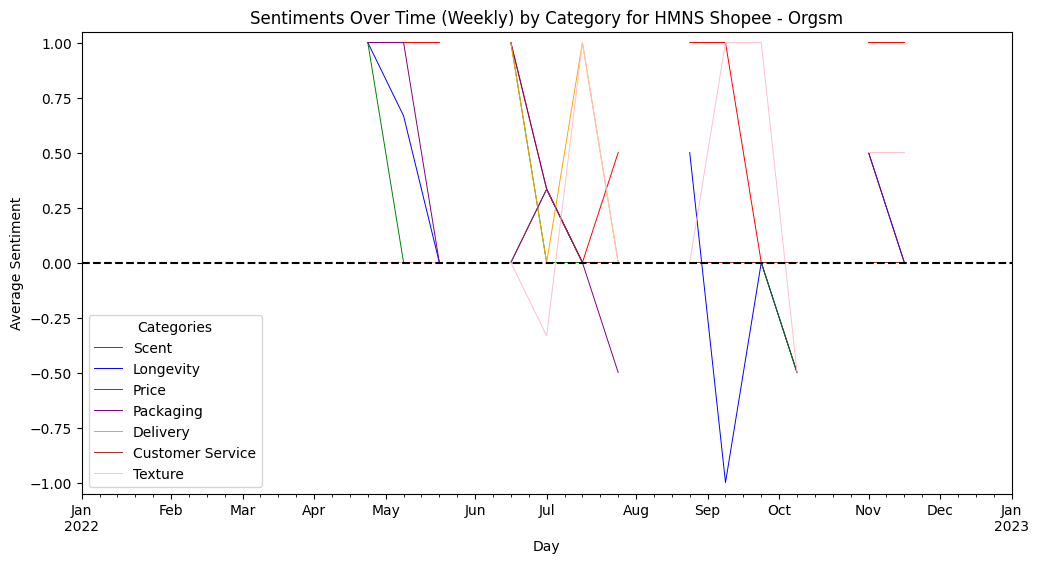

In [184]:
# Function to extract the sentiment for a given category
def extract_category_sentiment(category_dict, category):
    if isinstance(category_dict, str):
        category_dict = ast.literal_eval(category_dict)
    return sentiment_mapping.get(category_dict.get(category, 'neutral'), 0)

# Filter the dataframe for "HMNS Shopee" brand and "Orgsm" product
orgsm_df = categories_df[(categories_df['Brand'] == 'Saff & Co shopee') & (categories_df['Product'] == 'Cascavel')]

# Define the categories
categories = ['Scent', 'Longevity', 'Price', 'Packaging', 'Delivery', 'Customer Service', 'Texture']

# Apply the function to create new columns for each category sentiment
for category in categories:
    orgsm_df[f'{category}_sentiment'] = orgsm_df['Categories'].apply(lambda x: extract_category_sentiment(x, category))

# Plot the data
plt.figure(figsize=(12, 6))
colors = {'Scent': 'red', 'Longevity': 'blue', 'Price': 'green', 'Packaging': 'purple', 'Delivery': 'orange', 'Customer Service': 'brown', 'Texture': 'pink'}
for category in categories:
    sentiments_plot = orgsm_df.groupby(pd.Grouper(key='Review Date', freq='2W'))[f'{category}_sentiment'].mean()
    sentiments_plot.plot(kind='line', color=colors[category], label=category, alpha=1, linewidth=0.7)

plt.axhline(y=0, color='black', linestyle='--') 
plt.xlabel('Day')
plt.ylabel('Average Sentiment')
plt.legend(title='Categories')
plt.title('Sentiments Over Time (Weekly) by Category for HMNS Shopee - Orgsm')

plt.xlim(pd.Timestamp('2022-01-01'), pd.Timestamp('2022-12-31'))
plt.ylim(-1.05, 1.05)
plt.show()

## 8. Group review counts by year

In [ ]:
# Segment the data by year
years = [2021, 2022, 2023, 2024]

# Create a dictionary to store DataFrames for each year
givaudan_df['Review Date'] = pd.to_datetime(givaudan_df['Review Date'])
yearly_data = {year: givaudan_df[givaudan_df['Review Date'].dt.year == year] for year in years}

# Create a new Excel writer
with pd.ExcelWriter('Givaudan/Counts_and_Percentages_by_Year.xlsx') as writer:
    for year, data in yearly_data.items():
        # Count by brand
        brand_counts = data['Brand'].value_counts()
        brand_percentage = (brand_counts / brand_counts.sum()) * 100

        # Create a DataFrame for brand counts and percentages
        brand_df = pd.DataFrame({'Count': brand_counts, 'Percentage': brand_percentage})

        # Count by product
        product_counts = data['Product'].value_counts()
        product_percentage = (product_counts / product_counts.sum()) * 100

        # Create a DataFrame for product counts and percentages
        product_df = pd.DataFrame({'Count': product_counts, 'Percentage': product_percentage})

        # Ensure the Product index is unique before setting it
        data_unique = data.drop_duplicates(subset='Product')
        product_df['Brand'] = data_unique.set_index('Product')['Brand']

        # Write to Excel
        brand_df.to_excel(writer, sheet_name=f'Brand_{year}', index=True)
        product_df.to_excel(writer, sheet_name=f'Product_{year}', index=True)
print("Data has been written to 'Givaudan/Counts_and_Percentages_by_Year.xlsx'")

Data has been written to 'Givaudan/Counts_and_Percentages_by_Year.xlsx'


#### File is augmented to include perfume notes and saved as Count_by_Year